In [1]:
%cd ..

/mnt/menrui/OFA


In [2]:
%ls

3836680545_2ccb331621_z.jpg.1  datasets.md  ofa_module/       test.jpg
checkpoints/                   evaluate.py  README.md         trainer.py
checkpoints.md                 examples/    requirements.txt  train.py
criterions/                    fairseq/     results/          utils/
data/                          models/      run_scripts/
dataset/                       notebooks/   tasks/


In [3]:
import torch
import numpy as np
from fairseq import utils,tasks
from utils import checkpoint_utils
from utils.eval_utils import eval_step
from tasks.mm_tasks.caption import CaptionTask
from models.ofa import OFAModel
from PIL import Image

In [4]:
use_cuda = torch.cuda.is_available()
use_fp16 = True

In [5]:
# Register caption task
tasks.register_task('caption',CaptionTask)

<function fairseq.tasks.register_task.<locals>.register_task_cls(cls)>

In [20]:
# Load pretrained ckpt & config
overrides={"bpe_dir":"utils/BPE", "eval_cider":False, "beam":5, "max_len_b":16, "no_repeat_ngram_size":3, "seed":7}
models, cfg, task = checkpoint_utils.load_model_ensemble_and_task(
        utils.split_paths('checkpoints/caption_large_best.pt'),
        arg_overrides=overrides
    )

2022-02-11 11:34:18 | INFO | tasks.mm_tasks.caption | source dictionary: 59457 types
2022-02-11 11:34:18 | INFO | tasks.mm_tasks.caption | target dictionary: 59457 types


In [7]:
# Show config
cfg

{'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 10, 'log_format': 'simple', 'log_file': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': True, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': 512, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': 'caption_module', 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': False, 'use_plasma_view': False, 'plasma_path': '/tmp/plasma'}, 'common_eval': {'_name': None, 'path': None, 'post_process': None, 'quiet': False, 'model_overrides': '

In [8]:
# Move models to GPU
for model in models:
    model.eval()
    if use_fp16:
        model.half()
    if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
        model.cuda()
    model.prepare_for_inference_(cfg)

In [9]:
# Initialize generator
generator = task.build_generator(models, cfg.generation)

In [10]:
# Image transform
from torchvision import transforms
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((cfg.task.patch_image_size, cfg.task.patch_image_size), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

/root/miniconda3/envs/ofa/lib/python3.7/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [11]:
# Text preprocess
bos_item = torch.LongTensor([task.src_dict.bos()])
eos_item = torch.LongTensor([task.src_dict.eos()])
pad_idx = task.src_dict.pad()
def encode_text(text, length=None, append_bos=False, append_eos=False):
    s = task.tgt_dict.encode_line(
        line=task.bpe.encode(text),
        add_if_not_exist=False,
        append_eos=False
    ).long()
    if length is not None:
        s = s[:length]
    if append_bos:
        s = torch.cat([bos_item, s])
    if append_eos:
        s = torch.cat([s, eos_item])
    return s

In [12]:
# Construct input for caption task
def construct_sample(image: Image):
    patch_image = patch_resize_transform(image).unsqueeze(0)
    patch_mask = torch.tensor([True])
    src_text = encode_text(" what does the image describe?", append_bos=True, append_eos=True).unsqueeze(0)
    src_length = torch.LongTensor([s.ne(pad_idx).long().sum() for s in src_text])
    sample = {
        "id":np.array(['42']),
        "net_input": {
            "src_tokens": src_text,
            "src_lengths": src_length,
            "patch_images": patch_image,
            "patch_masks": patch_mask
        }
    }
    return sample

In [13]:
# Download a image from COCO or you can use other images
!wget http://farm4.staticflickr.com/3539/3836680545_2ccb331621_z.jpg 
!mv 3836680545_2ccb331621_z.jpg  test.jpg

--2022-02-11 11:32:54--  http://farm4.staticflickr.com/3539/3836680545_2ccb331621_z.jpg
正在解析主机 farm4.staticflickr.com (farm4.staticflickr.com)... 13.35.66.99, 2600:9000:20e4:3000:0:5a51:64c9:c681, 2600:9000:20e4:be00:0:5a51:64c9:c681, ...
正在连接 farm4.staticflickr.com (farm4.staticflickr.com)|13.35.66.99|:80... 已连接。
已发出 HTTP 请求，正在等待回应... 301 Moved Permanently
位置：https://farm4.staticflickr.com/3539/3836680545_2ccb331621_z.jpg [跟随至新的 URL]
--2022-02-11 11:32:54--  https://farm4.staticflickr.com/3539/3836680545_2ccb331621_z.jpg
正在连接 farm4.staticflickr.com (farm4.staticflickr.com)|13.35.66.99|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：未指定 [image/jpeg]
正在保存至: “3836680545_2ccb331621_z.jpg”

    [ <=>                                   ] 134,347     --.-K/s 用时 0.1s      

2022-02-11 11:32:55 (1017 KB/s) - “3836680545_2ccb331621_z.jpg” 已保存 [134347]



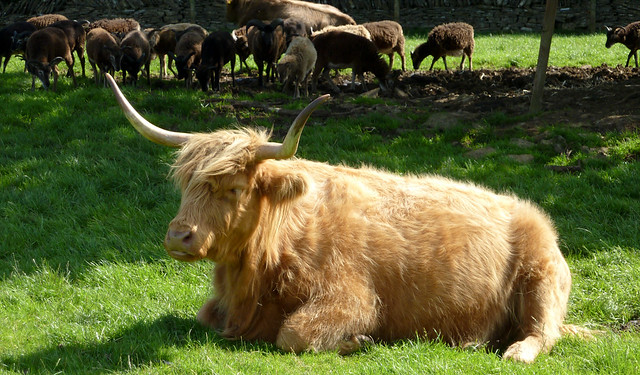

In [14]:
image = Image.open('./test.jpg')
display(image)

In [17]:
def apply_half(t):
    if t.dtype is torch.float32:
        return t.to(dtype=torch.half)
    return t

In [18]:
# Construct input sample & preprocess for GPU if cuda available
sample = construct_sample(image)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample
print(sample)

{'id': array(['42'], dtype='<U2'), 'net_input': {'src_tokens': tensor([[   0,   99,  473,    5, 2274, 6190,  116,    2]], device='cuda:0'), 'src_lengths': tensor([8], device='cuda:0'), 'patch_images': tensor([[[[-0.9453, -0.9922, -0.9844,  ..., -0.9292, -0.9531, -0.8901],
          [-0.9058, -0.9844, -0.9922,  ..., -0.8511, -0.8745, -0.8511],
          [-0.8354, -0.9370, -0.9844,  ..., -0.8354, -0.8511, -0.8276],
          ...,
          [ 0.0588,  0.0353, -0.0118,  ...,  0.1921,  0.0118,  0.0118],
          [ 0.0275, -0.0510,  0.0588,  ...,  0.1765, -0.1137, -0.1530],
          [ 0.1608, -0.0275,  0.1608,  ...,  0.0196, -0.0039, -0.0118]],

         [[-0.8979, -0.9609, -0.9609,  ..., -0.8198, -0.8433, -0.8433],
          [-0.8589, -0.9453, -0.9609,  ..., -0.7490, -0.7646, -0.8037],
          [-0.7959, -0.8901, -0.9453,  ..., -0.7412, -0.7490, -0.7881],
          ...,
          [ 0.3569,  0.3176,  0.2549,  ...,  0.4824,  0.3254,  0.3254],
          [ 0.3254,  0.2079,  0.3176,  ...,  0.

In [19]:
# Run eval step for caption
with torch.no_grad():
    result, scores = eval_step(task, generator, models, sample)
print(result)

[{'image_id': '42', 'caption': 'a horned cow laying in a field with other animals'}]
